## Uncertainty Estimation

We have seen that it was possible to obtain reasonably good estimates of the parameters, even with noisy fields values. However, it is crucial for practical application to also have an estimation uncertainty. 

In order to obtain uncertainty estimation values, we need to introduce a Bayesian framework. This means introducing some priors over the parameters. This should not be an issue since we normally would have nominal values for the components, or at least reasonable guesses or intervals for the values. 

Next we need to decide how to frame the optimization in the Bayesian framework. Here are some options: 

1. MAP estimate & Laplace estimate around the posterior mode: with this approach the prior influences the optimization with via a penalty term on the loss. Gradient based optimization (Adam) can then be employed to find the optimum, which in this case would be the MAP estimate. Finally, we assume the posterior is a Gaussian and we calculate the best fit using the Laplace approximation, which relies on computing the Hessian.

2. VI approach: should still be possible to use automatic-diff + Adam. 

3. HMC / NUTS: Since we only have 10 dimensions, there is no curse of dimensionality. Should be possible to draw **exact values from the posterior** without relying on surrogate models.  

4. Expectation Propagation (EP) Approaches: good with time-series. To be investigated. 

## Prior Distribution Family over the Physical Parameters

In [1]:
from pathlib import Path
from typing import List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

import h5py
import numpy as np


# change the working directory to the root of the project
sys.path.append(str(Path.cwd().parent))


from pinn_buck.config import Parameters
from pinn_buck.config import TRUE as TRUE_PARAMS, INITIAL_GUESS as INITIAL_GUESS_PARAMS
from pinn_buck.config import _SCALE

# load measurement interface
from pinn_buck.io import Measurement
from pinn_buck.noise import add_noise_to_Measurement

from pinn_buck.parameter_transformation import make_log_param, reverse_log_param
from pinn_buck.model.model_param_estimator import BuckParamEstimator
from pinn_buck.model.losses import l2_loss
from pinn_buck.io_model import TrainingRun

from pinn_buck.io import LoaderH5

### Parameter Nominal Values 

Now we need to define some nominal values for the parameters together with some realistic uncertainty estimates to simulate real engineering tasks. 

| Parameter | Description           | Nominal (N) | Tolerance / σ | Justification                      |
| --------- | --------------------- | ----------- | ------------- | ---------------------------------- |
| L         | Inductance            | 680 µH      | ±20%          | ±20% common for inductors          |
| RL        | Inductor resistance   | 0.3 Ω       | ±0.1 Ω        | DCR variation or estimation        |
| C         | Output capacitance    | 150 µF      | ±20%          | Electrolytics have wide tolerances |
| RC        | ESR of output cap     | 0.25 Ω      | ±40%          | Datasheet often gives a max        |
| Rdson     | Switch on-resistance  | 0.2 Ω       | ±10%          | MOSFETs vary with temperature      |
| Rload1    | Load resistor 1       | 3.3 Ω       | ±5%           | Depends on load spec               |
| Rload2    | Load resistor 2       | 10 Ω        | ±5%           | As above                           |
| Rload3    | Load resistor 3       | 6.8 Ω       | ±5%           | As above                           |
| Vin       | Input voltage         | 48 V        | ±2%           | From a regulated supply            |
| VF        | Diode forward voltage | 0.9 V       | ±0.1 V        | Varies with current/temperature    |


---

### Prior distribution family:
 we have to consider **Additive vs. Multiplicative Variation**.

* **Additive variation** means the component deviates by **adding or subtracting** some noise:

  $$
  x = x_0 + \epsilon
  \quad\text{(e.g., } \epsilon \sim \mathcal{N}(0, \sigma^2)\text{)}
  $$

  This is typical of **normal (Gaussian)** noise.

* **Multiplicative variation** means the component value varies by being **scaled** up or down:

  $$
  x = x_0 \cdot (1 + \delta)
  \quad\text{(e.g., } \delta \sim \mathcal{N}(0, \sigma^2)\text{)}
  $$

  Or more generally:

  $$
  \log x \sim \mathcal{N}(\mu, \sigma^2)
  \Rightarrow x \sim \text{LogNormal}(\mu, \sigma^2)
  $$

  This results in a **log-normal distribution** in linear space.

Considering how the components are manufactured:

* Component tolerances are often specified **as a percentage** (e.g., ±5%, ±10%).
* This means that the error **scales** with the magnitude.
* Example:

  * A 1 kΩ resistor with 5% tolerance → 950–1050 Ω
  * A 10 kΩ resistor with 5% tolerance → 9500–10500 Ω
    So the **absolute error grows** with the nominal value.

---

### Implication for Priors

If component values are specified with **percentage tolerances**, then we should model the distributions as:

$$
\log(x) \sim \mathcal{N}(\log(x_0), \sigma^2)
\quad\Rightarrow\quad
x \sim \text{LogNormal}
$$

This ensures:

* **Positivity**
* **Correct scaling of uncertainty**
* **Realistic tails** (e.g., 3σ errors reflect real-world max/min limits)


A log-normal distribution is suitable because:

* All parameters are positive
* Datasheet tolerances are multiplicative (e.g. ±20%)

For each parameter θ:

$$
p(\theta) = \frac{1}{\theta \sigma \sqrt{2\pi}} \exp\left( -\frac{(\log \theta - \mu)^2}{2\sigma^2} \right)
$$

Where:

* μ = log(nominal value)
* σ = log(1 + relative tolerance)

## Notes
it may be more realistic to set a normal or truncated normal for some parameters, e.g. V_in, R_loads, but for now let's assume a lognormal for all components. 

However, setting all priors to be a log-normal is a good initial choice, since: 

1. Log-normal distributions naturally enforce positivity, which is a desirable property for **every parameter** in your model.

2. If the **relative standard deviation** is small (say < 10%), then a log-normal is **almost symmetric** and looks very much like a normal.

3. Modeling simplicity of using a log-normal for all parameters means:
    * One consistent implementation for priors
    * All prior PDFs live in log-space → simple KL terms in VI
    * Posterior approximations (Laplace, variational) share the same structure

    This pays off during training, debugging, and when visualizing uncertainty.

---

### ⚠️ Risks of using Log-Normal 

The core issue here is **how the prior interacts with the likelihood** to shape the posterior when the prior is **skewed** (like a log-normal) and the likelihood is **tight** (very confident).
 
#### log-normal priors can become problematic in narrow posterior regimes

Log-normal distributions are **asymmetric**:

* The **mode** is less than the **mean**
* The density decays **faster** on the left (toward 0) than on the right

Now suppose the **likelihood (data)** is very confident about, say, $V_{in} = 48.1 \, \text{V}$, with very little uncertainty:

  1. The prior is **skewed right**:

      * Most mass is slightly above 48 V

      * The mode is < 48 V (since log-normal mode = exp(μ − σ²))

  2. The posterior, which is proportional to:

  $$
  \text{posterior} \propto \text{likelihood} \times \text{prior}
  $$

  gets **pulled** by this skewed prior.



> If the data is highly informative and points to a value slightly **above** the nominal (e.g. 48.1 V), the **log-normal prior puts less mass there** than a normal would. 
    * The posterior mean gets **pulled lower**
    * The posterior becomes **skewed left**
    * The Laplace approximation (Gaussian) might **not match** the real shape

So if your posterior is very concentrated and the prior is skewed, **even a small mismatch** between the likelihood peak and the prior mode can:

* Shift the posterior
* Lead to incorrect uncertainty quantification
* Mislead downstream predictions if you're sampling
    Result:


---

## ✅ Why a normal prior helps in this case

A **normal prior** is symmetric. So:

* It doesn't bias the posterior toward lower or higher values
* The posterior stays centered where the data wants it to be
* The Laplace (or mean-field VI) approximation is more accurate

In summary, consider changing to a normal only if:

* The posteriors for $V_{in}$ or $R_{\text{load}}$ are **very tightly concentrated**, and
* Your Laplace or VI posterior is **asymmetric or biased** due to the log-normal prior's skew


In [2]:
import matplotlib
from scipy.stats import lognorm
from pinn_buck.config import Parameters


# Nominals and linear-space relative tolerances
NOMINAL = Parameters(
    L=6.8e-4,
    RL=0.4,
    C=1.5e-4,
    RC=0.25,
    Rdson=0.25,
    Rload1=3.3,
    Rload2=10.0,
    Rload3=6.8,
    Vin=46.0,
    VF=1.1,
)

REL_TOL = Parameters(
    L=0.50,
    RL=0.4,
    C=0.50,
    RC=0.50,
    Rdson=0.5,
    Rload1=0.3,
    Rload2=0.3,
    Rload3=0.3,
    Vin=0.3,
    VF=0.3,
)


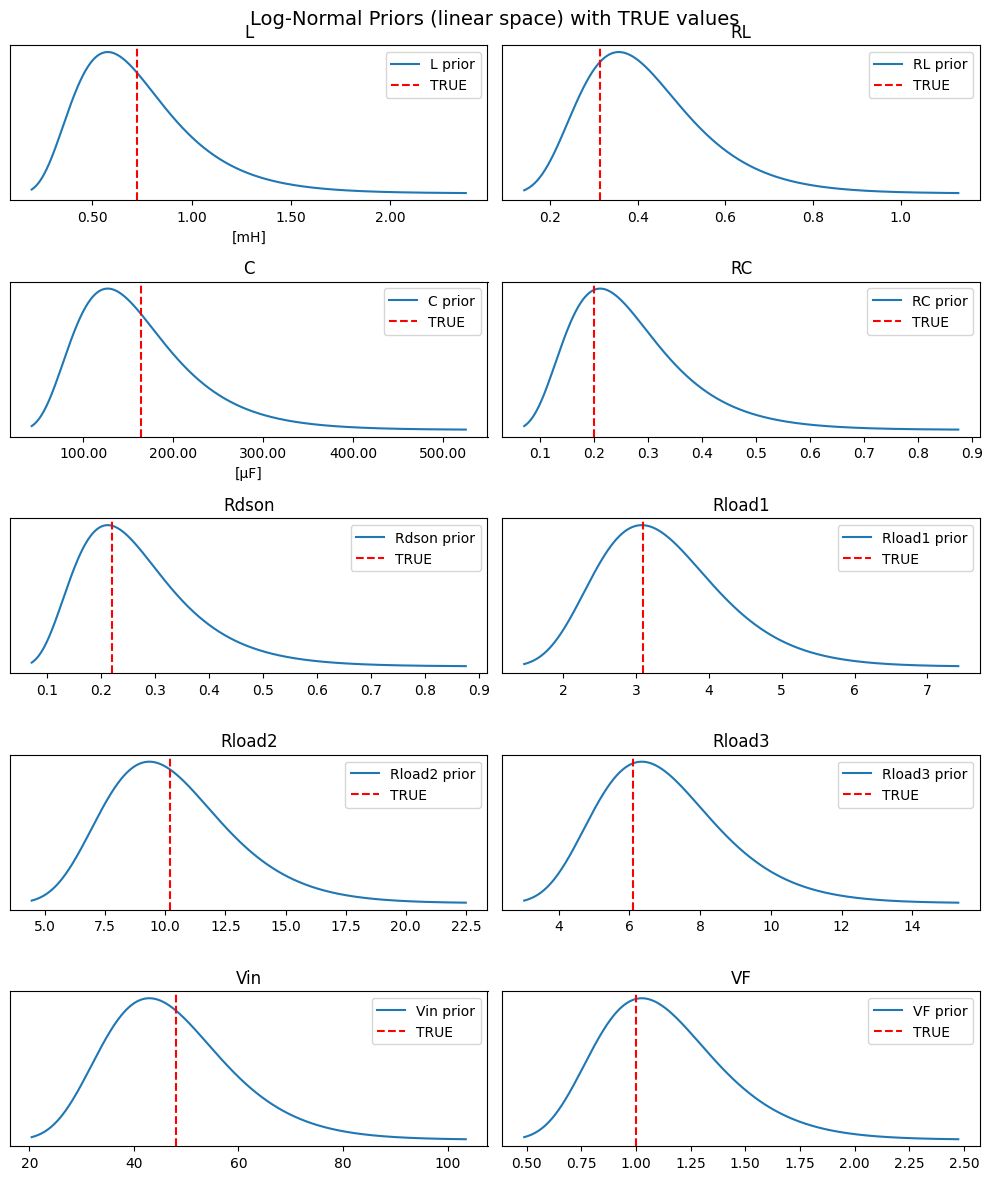

In [3]:

%matplotlib inline
import matplotlib.pyplot as plt

# Plotting
param_names = Parameters._fields
ncols = 2
nrows = int(np.ceil(len(param_names) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12))
axes = axes.flatten()

for i, name in enumerate(param_names):
    nominal = getattr(NOMINAL, name)
    rel_tol = getattr(REL_TOL, name)
    true_val = getattr(TRUE_PARAMS, name)

    # log-normal parameters
    sigma = np.log(1 + rel_tol)
    mu = np.log(nominal)

    dist = lognorm(s=sigma, scale=np.exp(mu))

    x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 500)
    pdf = dist.pdf(x)

    ax = axes[i]
    ax.plot(x, pdf, label=f"{name} prior")
    ax.axvline(true_val, color="red", linestyle="--", label="TRUE")
    ax.set_title(name)
    ax.set_yticks([])
    ax.legend()
    
    if name == "L":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
        ax.set_xlabel("[mH]")
    if name == "C":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
        ax.set_xlabel("[μF]")

fig.suptitle("Log-Normal Priors (linear space) with TRUE values", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

## Benchmark

Let's inspect a normal run of the Adam optimizer with the nominal values as initial guess

In [4]:
import torch
import torch.nn as nn


def set_seed(seed: int = 1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def train_from_measurement_file(
    meas: Measurement,
    initial_guess_params: Parameters,
    savename: str = "saved_run",
    db_dir: Path = ".",
    lr: float = 1e-3,
    epochs: int = 30_000,
    device: str = "cpu",
    patience: int = 5000,
    lr_reduction_factor: float = 0.5,
):
    # load the transient data as unified numpy arrays
    X, y = meas.data
    s1, s2, s3 = list(
        map(lambda x: x - 1, meas.transient_lengths)
    )  # subtract 1 since we use the previous time step as input
    lb, ub = X.min(0), X.max(0)

    X_t = torch.tensor(X, device=device)
    y_t = torch.tensor(y, device=device)
    x0 = X_t[:, :2]

    # Model
    model = BuckParamEstimator(lb, ub, s1, s2, s3, initial_guess_params).to(device)

    history_loss = []
    history_params: List[Parameters] = []
    learning_rates: List[float] = []

    # --- tracking best loss ---
    best_loss, best_iter = float("inf"), -1

    # Optimization
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=lr_reduction_factor, patience=patience
    )

    for it in range(epochs):
        optimizer.zero_grad()
        pred = model(X_t, y_t)
        # loss = compute_loss(pred, x0, y_t) if it < epochs1 else compute_L1_loss(pred, x0, y_t)

        loss = l2_loss(pred, x0, y_t)
        loss.backward()

        optimizer.step()
        scheduler.step(loss)
        
        if it % 1000 == 0:
            est = model.get_estimates()
            history_loss.append(loss.item())
            history_params.append(est)
            # record the learning rate
            learning_rates.append(optimizer.param_groups[0]["lr"])

            if loss.item() < best_loss:
                best_loss = loss.item()
                best_iter = it

            # print the parameter estimation
            est = model.get_estimates()
            print(
                f"Iteration {it}, loss {loss:4e},  Parameters (Adam):",
                f"L={est.L:.3e}, RL={est.RL:.3e}, C={est.C:.3e}, "
                f"RC={est.RC:.3e}, Rdson={est.Rdson:.3e}, "
                f"Rload1={est.Rload1:.3e}, Rload2={est.Rload2:.3e}, "
                f"Rload3={est.Rload3:.3e}, Vin={est.Vin:.3f}, VF={est.VF:.3e}",
            )

    # Save the history to a CSV file
    training_run = TrainingRun.from_histories(
        loss_history=history_loss,
        param_history=history_params,
    )

    # generate the output directory if it doesn't exist
    db_dir.mkdir(parents=True, exist_ok=True)

    # if savename doesn't end with .csv, add it
    if not savename.endswith(".csv"):
        savename += ".csv"

    training_run.save_to_csv(db_dir / savename)
    print("Concluded ADAM training.")

In [5]:
set_seed(123)
device = "cpu"

# Load and assemble dataset
db_dir = Path(r"C:/Users/JC28LS/OneDrive - Aalborg Universitet/Desktop/Work/Databases")
h5filename = "buck_converter_Shuai_processed.h5"

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    3: "5 noise",
    4: "10 noise",
}


lr = 1e-3
epochs = 20_000
patience = 5000
device = "cpu"  # or "cuda" if you have a GPU
lr_reduction_factor = 0.5


out_dir = Path.cwd().parent / "RESULTS" / "Bayesian" / "Adam"

# noisy_measurements = {}
# for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
#     if "Sync" in group_name:
#         # Skip the Sync Error group for now
#         continue
#     print(f"Loading group {group_number}: {group_name}")
#     # Load the data from the hdf5 file
#     io = LoaderH5(db_dir, h5filename)
#     io.load(group_name)

#     # Store the measurement in a dictionary
#     noisy_measurements[group_name] = io.M

#     print(f"\n{'-'*50}")
#     print(f"{idx}) Training with {group_name} data")

#     # Train the model on the noisy measurement
#     train_from_measurement_file(
#         io.M,
#         initial_guess_params= NOMINAL,
#         db_dir=out_dir,
#         savename=f"noisy_run_{group_name}.csv",
#         lr=lr,
#         patience=patience,
#         lr_reduction_factor=lr_reduction_factor,
#         epochs=epochs_1,
#         device=device,
#     )

Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_ideal.csv


<Axes: title={'center': 'Final Percentage Error of Parameters'}, ylabel='Percentage Error (%)'>

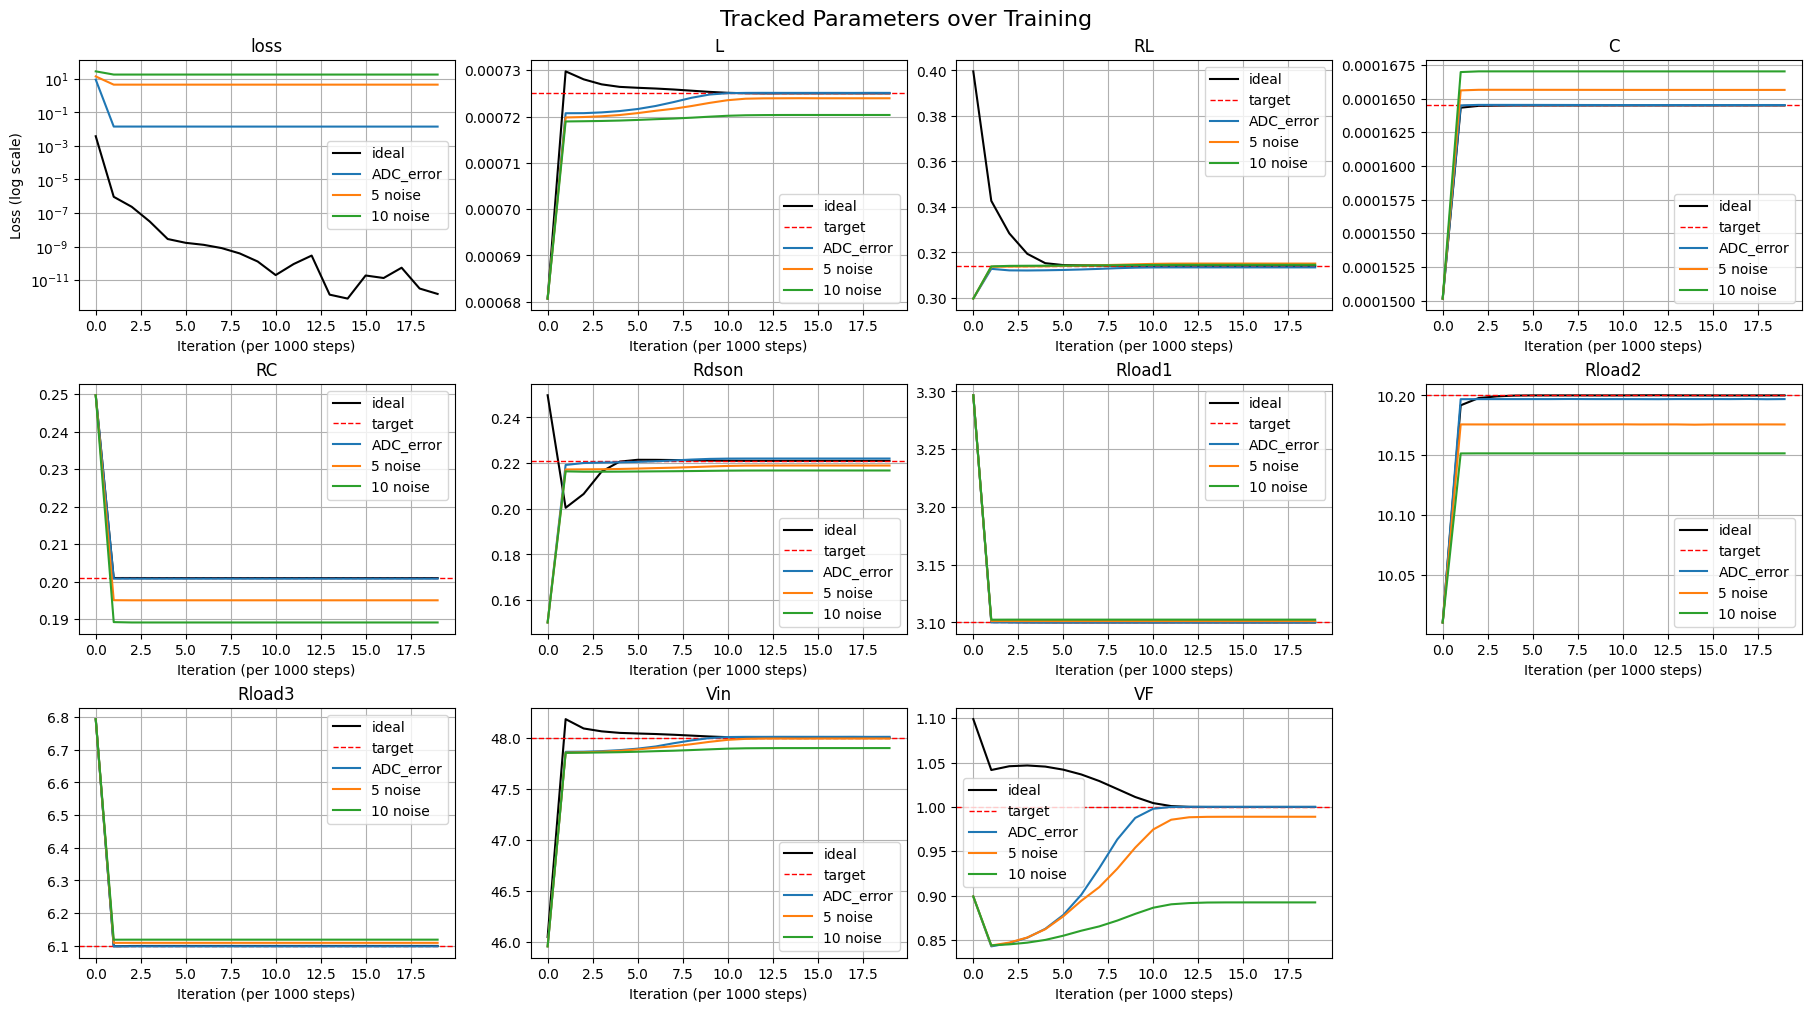

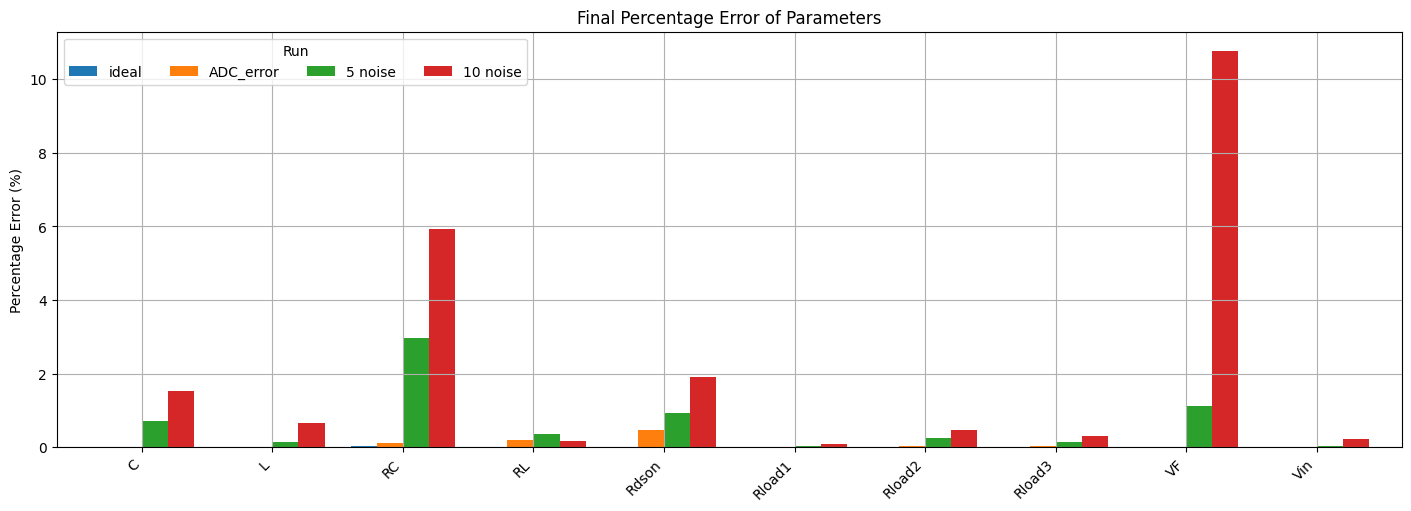

In [6]:
from pinn_buck.plot_utils import (
    plot_tracked_parameters,
    plot_final_percentage_error,
    plot_final_percentage_error_multi,
)

# loop through all CSV files in the directory
csv_files = list(out_dir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}


for ii in (0, 1, 3, 4):
    tr = runs[GROUP_NUMBER_DICT[ii]]
    label = GROUP_NUMBER_DICT[ii]
    if ii == 0:
        fig, ax = plot_tracked_parameters(
            df=tr,
            target=TRUE_PARAMS,
            label=label,
            color="black",
            figsize=(18, 10),
        )
        continue

    plot_tracked_parameters(df=tr, target=None, label=label, ax=ax, color=None)

runs_ordered = {GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)}

plot_final_percentage_error_multi(
    runs=runs_ordered, target=TRUE_PARAMS, figsize=(14, 5), select_lowest_loss=False
)

## MAP Estimation

In order to get a MAP estimation, we have to consider the priors and try to maximize the posterior distribution on the parameters following Bayes' rule: 
$$ p(z | x = D) = p(x=D | z) \cdot p(z) / p(x=D) $$
However, even in this low dimensional case with 10 latent parameters $z$, which are the physical parameters of the circuit, it is difficult to numerically compute the marginal $$p(x=D) = \int_z p(x=D | z) p(z) dz$$

However, we know that the marginal does not depend on the particular choice of z, so the level set for fixed x=D of the joint $p(x=D, z) = p(x=D | z) \cdot p(z)$ is proportional to the posterior: 
$$ p(z | x = D) \propto  p(x=D, z)$$
Then it is possible to get the MAP solely by analyzing the joint distribution since: 
$$ \argmax_z p(z | x=D) = \argmax_z p(x=D, z)$$

In this application we have a supervised model, so
$$y = f(x, z)$$
And he dataset is $\mathcal D=\{(x_i,\,y_i)\}_{i=0}^{N-1}$.

We can rewrite: 
$$ p(z | x, y = D) \propto  p(y=D_y, z | x=D_x) =  p(y = D_y \mid x, z) p(z)$$

### Definition of the loss function
Now we can elaborate on the expression of the MAP estimate, that searches for $z_{\text{MAP}}=\argmax_z p(y=D, z | x)$. To this end, we chose the Negative Log Likelihood as a loss function

\begin{align}
    \text{NLL}(z) &= - \log p(y=D, z | x) \\
    &= -\log p(y=D | z, x) - \log p(z)
\end{align}

With the hypothesis of independent draws of the observed variables x that form the dataset: 
$$ p(y=D | z, x) = \prod_{i=0}^{N-1} p(y_i | x_i, z) $$


## Consider the choice of Distribution

### Prior
We have chosen a Log-Normal distribution to represent the pdf over the circuit parameters: 
$$p(x) = \frac{1}{x \sigma \sqrt{2\pi}} \exp\left( -\frac{(\log x - \mu)^2}{2\sigma^2} \right)$$

or equivalently $\log x \sim \mathcal{N}(x; \mu, \sigma)$:

$$p(\log x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(\log x - \mu)^2}{2\sigma^2}\right)$$

Then: 
\begin{align}
    \log p(\log z) &= \log \left[\frac{1}{\sqrt{2\pi\sigma_0^2}} \exp\left(-\frac{(\log z - \mu_0)^2}{2\sigma_0^2}\right)\right]\\
                & \propto -\frac{(\log z - \mu_0)^2}{2\sigma_0^2}
\end{align}

Assuming the priors are independently drawn: 
$$
\log p(\log z)= -\frac{1}{2}\sum_{k=1}^{10}
      \frac{\bigl(z_k-\mu_{0,k}\bigr)^{2}}{\sigma_{0,k}^{2}}+\text{const}.
$$



### Likelihood
Assuming the **observations** $\{x_i\}_{i=0}^{N-1}$ are  corrupted by additive homoscedastic Gaussian sensor noise, so the observation random variables are **independent and Gaussian distributed** with a likelihood of the form $y_i \mid x_i,z \;\sim\; \mathcal N\!\bigl(f(x_i,z),\,\sigma_x^{2}\mathbf I\bigr)$, the total log-likelihood is:

$$
\log p(\mathbf y\mid\mathbf x,z)
  = -\frac{1}{2\sigma_x^{2}}\sum_{i=0}^{N-1}\!
      \bigl\|\,y_i-f(x_i,z)\bigr\|^{2} + \text{const}.
$$
Note that $\sigma_x$ is the noise in the observed dataset. However, it can be useful to instead consider the distribution of residuals $r_n = y - f(x,z)$, which, if for now we consider $f(x,z)$ deterministic, is $r_n \sim \mathcal{N}(0, \sigma_x^{2}\mathbf I)$, i.e. **it also exhibits an uncertainty derived from the data noise $\sigma_x$**.  

### NLL - MAP objective
So the nnegative log likelihood becomes: 
$$ \text{NLL}(z)=
\frac{1}{2\sigma_x^{2}}
      \sum_{i=0}^{N-1}\!\bigl\|y_i-f(x_i,z)\bigr\|^{2}
+\frac{1}{2}\sum_{k=1}^{10}
      \frac{\bigl(\log z_k-\mu_{0,k}\bigr)^{2}}{\sigma_{0,k}^{2}}
+ \text{const}.
$$

Note that we assume a fixed variance of the observation that doesn't depend on the values of the input parameters, i.e. we assume **homoschedasticity**. Note that this makes sense: 
    
>  "The parameters determine the mean values of the observed data with some random noise whose variance depends on random factors, independent on the data."

Many times, the prior assumptions are weak and therefore, therefore $\sigma_0$ is allowed to control the data-prior balance entirely. However, in our case we are considering different solutions with different noise powers. Therefore, we should consider both $\sigma_x$ and $\sigma_0$ explicitly. We can rewrite the NLL as: 

$$\text{NLL}(z) = \frac{1}{2\sigma_x^2} \left[
      \sum_{i=0}^{N-1}\!\bigl\|y_i-f(x_i,z)\bigr\|^{2}
+ \frac{\sigma_x^2}{\sigma_0^2} \sum_{k=1}^{10}
      \bigl(\log z_k-\mu_{0,k}\bigr)^{2}
\right] + \text{const.}$$

Since $\frac{1}{2\sigma_x^2}$ only changes the scale of the NLL we can ignore this term to obtain:

$$\text{NLL}(z) = \sum_{i=0}^{N-1}\!\bigl\|y_i-f(x_i,z)\bigr\|^{2}
+ \underbrace{\frac{\sigma_x^2}{\sigma_0^2}}_\lambda \sum_{k=1}^{10}
      \bigl(\log z_k-\mu_{0,k}\bigr)^{2} + \text{const.}$$

Here we can set $\frac{\sigma_x^2}{\sigma_0^2}=\lambda$ and we can see that we obtain a new parameter that regulates how much weights we want to give to the prior. Indeed, if the data is noisy, then $\lambda \uparrow$ and the prior has a stronger influence on the loss, while if the data noise is very low, $\lambda \downarrow$ and we quickly move away from our prior convictions. 

It is common in these setups to directly tune $\lambda$ as a hyperparameter, for example via cross-validation and grid search. However, in our case there is a strong physical interpretation for these quantities and we may have a meaningful insite on the prior range on the parameters from datasheets or manufactorers. Moreover, we may also have some knowledge on the noise present in our measurements. Therefore, we can maintain the original expression for the posterior loss:

$$\text{NLL}(z)=
\frac{1}{2\sigma_x^{2}}
      \sum_{i=0}^{N-1}\!\bigl\|y_i-f(x_i,z)\bigr\|^{2}
+\frac{1}{2}\sum_{k=1}^{10}
      \frac{\bigl(\log z_k-\mu_{0,k}\bigr)^{2}}{\sigma_{0,k}^{2}}
+ \text{const}.$$


## Noisy Observations

In the previously described model, all observation noise was attributed to the target variable:

$$
y \sim \mathcal{N}(f(x, z), \sigma_x^2).
$$

However, in our specific setup, the target $y = x_{n+1}$ is itself an observed state, and so is the input $x = x_n$. Both are corrupted by measurement noise of the same variance:

$$
x_n^{\text{obs}} = \tilde{x}_n + \eta_n, \quad \eta_n \sim \mathcal{N}(0, \sigma_x^2),
$$

$$
y_n^{\text{obs}} = x_{n+1}^{\text{obs}}.
$$

We use a deterministic model $f(z, x_n)$, typically an RK4 integrator, to predict the next state. The residuals between the noisy target and the prediction are:

$$
r_n(z) = y_n^{\text{obs}} - f(z, x_n^{\text{obs}}).
$$

If noise levels were unknown, we could estimate the total predictive variance directly from the residuals:

$$
\hat{\sigma}_{\text{tot}}^2 = \frac{1}{N} \sum_{n=1}^N \left( r_n^{\text{nom}} - \bar{r}^{\text{nom}} \right)^2,
$$

where the residuals are computed using the nominal parameters $z_{\text{nom}}$. This is effectively empirical risk minimization and yields an approximate observation noise model, albeit biased by imperfect parameters.

---

### Analytical Estimation (When Noise is Known)
We have a noisy observation $x^{\text{obs}}\!\sim\!\mathcal N(x,\sigma_x^2)$ and the forward model is a scalar
$y^{\text{obs}}=f(x^{\text{obs}})$.

Let us consider the residual we want to minimize: 
$r_n^{\text{obs}} = x_{n}^{\text{pred}}-x_{n}^{\text{obs}}$

Then we see that: 
$$x_{n}^{\text{pred}} = f(x_{n-1}^{\text{obs}})$$


We can approximate the function with the first order Taylor expansion:
\begin{align}
f(x_{n-1}^{\text{obs}}) &= f(x_{n-1} + \varepsilon_{n-1}) \\
&\simeq f(x_{n-1}) + \frac{\partial f}{\partial x} \varepsilon_{n-1}
\end{align}

Where $\frac{\partial f}{\partial x}$ is the Jacobian $J$
Putting everything together we get: 
\begin{align}
r_n^{\text{obs}} &= f(x_{n-1}) - x_n + J \varepsilon_{n-1} - \varepsilon_{n}\\
&= r_{n} + \epsilon_{r}
\end{align}

So $r_n \sim \mathcal{N}(r_{n}, \Sigma_r)$.

We can calculate the variance by looking at the random variable $\varepsilon_{r} = J \varepsilon_{n-1} - \varepsilon_{n}$. Since we assume the noise on the data is white gaussian noise, so $\varepsilon_{n-1}$ and \varepsilon_{n-1}$ are independent, we get: 

$$\operatorname{Var}[r_n^{\text{obs}}] = ||J||^2 \Sigma_x + \Sigma_x = (1+||J||_F^2) \Sigma_x$$

In conclusion: 
$$
\boxed{
   r_n^{\text{obs}} \sim \mathcal{N}(r_{n}, (1+||J||_F^2)\Sigma_x)
}
$$

This decomposition highlights that uncertainty propagates from $x_n$ through the model via its Jacobian with respect to $x$. Thus, even if the model is deterministic, input uncertainty affects the output distribution.

#### Interpretation and Estimation of the Jacobian

Importantly, the Jacobian, i.e. the derivative $\partial f / \partial x$, is **not** a time derivative like $(x_{n+1} - x_n) / dt$. It is a sensitivity derivative that answers the question:

> *"How much would the prediction $f(z, x_n)$ change if I slightly perturbed the input $x_n$?"*

This derivative captures how uncertainty in the current state propagates into uncertainty in the next predicted state.

We then need to numerically estimate the Jacobian norm:

$$
\left\langle \|J(z_\text{nom})\|_F^2 \right\rangle_n,
$$

This can be done by looping through the training inputs $x_n$, computing the Jacobian with respect to the model input $x_n$ via autograd, and aggregating the squared norm of these matrices. Obviously, the derivatives depends also on the latent parameters $z$, which are unknown before training. However, we can use the nominal values to provide a good guess. 

This yields a scalar correction factor that adjusts the data loss scale in the MAP objective.


## Independent v and i noises

In practice the noise levels on v and i can be quite different. Moreover, the estimation of the voltage in the next location will depend on both previous voltage and current as well as the current in the next step will depend on both previous voltage and current. However, the sensitivity to one may be different from the sensitivity to the other. Therefore we have to consider the full 2x2 Jacobian.


#### 2 .  Vector case with diagonal noise

Let the measured state be

$$
x_n^{\text{obs}}=(i_n^{\text{obs}},\,v_n^{\text{obs}})^\top,
\qquad
y_n^{\text{obs}}=(i_{n+1}^{\text{obs}},\,v_{n+1}^{\text{obs}})^\top .
$$

Assume **independent** noises

$$
\Sigma_x=\mathrm{diag}\!\bigl(\sigma_i^{2},\;\sigma_v^{2}\bigr),\qquad
\Sigma_y=\mathrm{diag}\!\bigl(\sigma_i^{2},\;\sigma_v^{2}\bigr),
$$

and let

$$
J=\frac{\partial f}{\partial x}
=\begin{bmatrix}
J_{11}&J_{12}\\[2pt]
J_{21}&J_{22}
\end{bmatrix}\in\mathbb R^{2\times2}.
$$

The residual covariance is

$$
\boxed{
\Sigma_{\text{tot}}
   =\Sigma_x + J\,\Sigma_x\,J^\top
}
$$



In [35]:
from typing import Callable, Union, Iterable
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from contextlib import contextmanager
import math

# let's define a function to convert relative tolerances to standard deviations
# using the log-normal distribution assumption.
# Previously, we assumed sigma = log(1 + rel_tol). This means we assume that the relative toleraces contain 1 standard deviation
# of the data. Although usually the relative tolerances are defined as 2 or 3 standard deviations, we will use 1 standard deviation
# since this is the worst case scenario.

def rel_tolerance_to_sigma(rel_tol: Parameters) -> Parameters:
    """Convert relative tolerances to standard deviations."""

    def _to_sigma(value: float) -> torch.Tensor:
        """Convert a relative tolerance to standard deviation."""
        return torch.log(torch.tensor(1 + value, dtype=torch.float32))

    return Parameters(
        L=_to_sigma(rel_tol.L),
        RL=_to_sigma(rel_tol.RL),
        C=_to_sigma(rel_tol.C),
        RC=_to_sigma(rel_tol.RC),
        Rdson=_to_sigma(rel_tol.Rdson),
        Rload1=_to_sigma(rel_tol.Rload1),
        Rload2=_to_sigma(rel_tol.Rload2),
        Rload3=_to_sigma(rel_tol.Rload3),
        Vin=_to_sigma(rel_tol.Vin),
        VF=_to_sigma(rel_tol.VF),
    )

# define the log-normal prior for the parameters assuming independent priors distrubuted according to the log-normal distribution.
# See the formula above.
def log_normal_prior(logparams: Parameters, nominal: Parameters, sigma: Parameters) -> torch.Tensor:
    """Return −log p(log z) assuming independent log-normal priors."""
    total = 0.0
    nominal_logparams = make_log_param(nominal)
    for name in Parameters._fields:
        proposed_value = getattr(logparams, name)
        mu = getattr(nominal_logparams, name)
        sig = getattr(sigma, name)
        total += ((proposed_value - mu) / sig) ** 2 / 2
    return total


def _parse_data_noise_to_sigma(data_noise: Union[float, Iterable, torch.Tensor]) -> torch.Tensor:
    """Parse data_noise and return the inverse covariance matrix Sigma_x_inv."""
    if isinstance(data_noise, float):
        a = data_noise
        b = data_noise
        return torch.diag(torch.tensor([a, b], dtype=torch.float32))
    elif isinstance(data_noise, torch.Tensor):
        if data_noise.shape != (2, 2):
            raise ValueError("If data_noise is a tensor, it must be 2x2.")
        return data_noise
    elif isinstance(data_noise, Iterable):
        data_noise = list(data_noise)
        if len(data_noise) != 2:
            raise ValueError("If data_noise is iterable, it must be of length 2.")
        a = data_noise[0]
        b = data_noise[1]
        return torch.diag(torch.tensor([a, b], dtype=torch.float32))
    else:
        raise TypeError("data_noise must be float, 2-tensor, or iterable of length 2.")


def likelihood_loss(preds, y_n, y_np1, Sigma_fwd: torch.Tensor, Sigma_bck: torch.Tensor) -> torch.Tensor:
    """
    Compute −log likelihood with Mahalanobis norm using per-variable covariance.
    preds: tuple of (i_n, v_n, i_np1, v_np1)
    y_n, y_np1: true values at time steps n and n+1
    Sigma_x_inv: 2x2 inverse covariance matrix for [i, v]
    """
    i_n, v_n, i_np1, v_np1 = preds
    i0, v0 = y_n[:, 0:1], y_n[:, 1:2]
    i1, v1 = y_np1[:, 0:1], y_np1[:, 1:2]

    # Residuals: shape [N, 2]
    res_0 = torch.cat([i_n - i0, v_n - v0], dim=1)
    res_1 = torch.cat([i_np1 - i1, v_np1 - v1], dim=1)
    
    # reiduals forward
    L_fwd = torch.linalg.cholesky(Sigma_fwd)  # (2,2), lower-tri
    z_fwd = torch.linalg.solve_triangular(L_fwd, res_0.T, upper=False).T
    res_0 = 0.5 * z_fwd.pow(2).sum()
    
    # reiduals backward
    L_bck = torch.linalg.cholesky(Sigma_bck)  # (2,2), lower-tri
    z_bck = torch.linalg.solve_triangular(L_bck, res_1.T, upper=False).T
    res_1 = 0.5 * z_bck.pow(2).sum()
    
    return res_0 + res_1


# define the loss function for MAP estimation that combines the L2 loss and the log-normal prior.
def make_map_loss(
    nominal: Parameters,
    sigma: Parameters,
    Sigma_fwd: Union[float, Iterable, torch.Tensor] = 1.0,
    Sigma_bck: Union[float, Iterable, torch.Tensor] = 1.0,
) -> Callable:

    Sigma_fwd = _parse_data_noise_to_sigma(Sigma_fwd)
    Sigma_bck = _parse_data_noise_to_sigma(Sigma_bck)   
    def _loss(model, preds, y_n, y_np1):
        ll = likelihood_loss(preds, y_n, y_np1, Sigma_fwd=Sigma_fwd, Sigma_bck=Sigma_bck)
        prior = log_normal_prior(model.logparams, nominal, sigma) 
        return ll + prior

    return _loss

In [31]:
from dataclasses import dataclass

# for simplicity let's define a dataclass for the training configurations
@dataclass
class AdamOptTrainingConfigs:
    savename: str = "saved_run"
    out_dir: Path = Path(".")
    lr: float = 1e-3
    epochs: int = 30_000
    epochs_lbfgs: int = 1500
    device: str = "cpu"
    patience: int = 5000
    lr_reduction_factor: float = 0.5


# Define the Trainer class for training the model using Adam. 
class Trainer:
    def __init__(self, model, loss_fn: Callable, optim_cfg: AdamOptTrainingConfigs, device="cpu"):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optim_cfg = optim_cfg
        self.device = device
        self.history = {"loss": [], "params": [], "lr": []}

    def fit(self, X, y, y_prev, epochs_adam=20_000, epochs_lbfgs=500, callback=None):

        X = X.detach().to(self.device)
        y = y.detach().to(self.device)
        y_prev = y_prev.detach().to(self.device)

        X = X.to(self.device)
        y = y.to(self.device)
        y_prev = y_prev.to(self.device)

        opt = torch.optim.Adam(self.model.parameters(), lr=self.optim_cfg.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt,
            mode="min",
            factor=self.optim_cfg.lr_reduction_factor,
            patience=self.optim_cfg.patience,
        )

        # Initialize the best loss
        best_loss = float("inf")

        for it in range(epochs_adam):
            opt.zero_grad()
            loss: torch.Tensor = self.loss_fn(self.model, self.model(X, y), y_prev, y)
            loss.backward()

            opt.step()
            scheduler.step(loss.item())

            # print("\nGradient check for log-parameters:")
            # for name in Parameters._fields:
            #     param = getattr(self.model, f"log_{name}")
            #     if param.grad is None:
            #         print(f"  log_{name}: grad = None ❌")
            #     else:
            #         norm = param.grad.norm().item()
            #         print(f"  log_{name}: grad norm = {norm:.3e} {'✅' if norm > 0 else '⚠️ zero'}")

            if it % 1000 == 0:
                est = self.model.get_estimates()
                self.history["loss"].append(loss.item())
                self.history["params"].append(est)
                # record the learning rate
                self.history["lr"].append(opt.param_groups[0]["lr"])

                if loss.item() < best_loss:
                    best_loss = loss.item()

                # print the parameter estimation
                grads = [getattr(self.model, f"log_{n}").grad.view(1) for n in Parameters._fields if getattr(self.model, f"log_{n}").grad is not None]

                if grads:
                    gradient_vector = torch.cat(grads)
                    gradient_norm = gradient_vector.norm().item()
                else:
                    gradient_norm = float('nan')  # no gradients found (shouldn't happen during training)

                print(
                    f"Iteration {it}, gradient_norm {gradient_norm:4e}, loss {loss:4e},  Parameters (Adam):",
                    f"L={est.L:.3e}, RL={est.RL:.3e}, C={est.C:.3e}, "
                    f"RC={est.RC:.3e}, Rdson={est.Rdson:.3e}, "
                    f"Rload1={est.Rload1:.3e}, Rload2={est.Rload2:.3e}, "
                    f"Rload3={est.Rload3:.3e}, Vin={est.Vin:.3f}, VF={est.VF:.3e}",
                )

        # # → LBFGS
        # LBFGS optimization tends to find stable solutions that also minimize the gradient norm.
        # This will be useful when we want to compute the Laplace posterior, which relies on the Hessian of the loss function.        
        
        print("Starting LBFGS optimization...")
        opt = torch.optim.LBFGS(
            self.model.parameters(),
            max_iter=epochs_lbfgs,
            line_search_fn="strong_wolfe",
            tolerance_grad=1e-8,
        )
        
        # update the histories with the last Adam iteration
        self.history["loss"].append(loss.item())
        self.history["params"].append(est)
        self.history["lr"].append(opt.param_groups[0]["lr"])

        # Save the history to a CSV file
        training_run = TrainingRun.from_histories(
            loss_history=self.history["loss"],
            param_history=self.history["params"],
        )

        # generate the output directory if it doesn't exist
        self.optim_cfg.out_dir.mkdir(parents=True, exist_ok=True)

        # if savename doesn't end with .csv, add it
        savename = self.optim_cfg.savename

        if not savename.endswith(".csv"):
            savename += ".csv"

        training_run.save_to_csv(self.optim_cfg.out_dir / savename)
        print("Concluded ADAM training.")

        def closure():
            opt.zero_grad()
            loss = self.loss_fn(self.model, self.model(X, y), y_prev, y)
            loss.backward()
            return loss

        opt.step(closure)

        # # calculate the Laplace posterior
        # theta_map, cov_log = laplace_posterior(
        # self.model, X, y, y_prev, self.loss_fn, damping=1e-6)

        # self.theta_map = theta_map      # save for later inspection
        # self.cov_log   = cov_log

        return self.model

In [32]:
# get data noise values

# ADC noise is 1 LSB, so we can assume that the data noise is 1 LSB
# 5 noise is 5 LSB, 10 noise is 10 LSB

# A least significant bit (LSB) is the smallest unit of data in a digital system and is calculated as:
#         LSB_i = I_FS / (2**12 - 1)  # assuming 12-bit ADC
#         LSB_v = V_FS / (2**12 - 1)  # assuming 12-bit ADC

# where I_FS is the full-scale current, set to 10 A and V_FS is the full-scale voltage set to 30 V (see 03_inspect_noisy_data.ipynb).

# Then the noise level is calculated as:
#         noise_level_i = noise_level * LSB_i  # normalize noise level to LSB
#         noise_level_v = noise_level * LSB_v  # normalize noise level to LSB

lsb_i = 10 / (2**12 - 1)  # 10 A full-scale current
lsb_v = 30 / (2**12 - 1)  # 30 V full-scale voltage

# i and v noise levels should probably be considered separately:

sigma_noise_ADC_i = 1 * lsb_i  # 1 LSB noise
sigma_noise_5_i = 5 * lsb_i  # 5 LSB noise
sigma_noise_10_i = 10 * lsb_i  # 10 LSB noise

sigma_noise_ADC_v = 1 * lsb_v  # 1 LSB noise
sigma_noise_5_v = 5 * lsb_v  # 5 LSB noise
sigma_noise_10_v = 10 * lsb_v  # 10 LSB noise

noise_power_ADC_i = sigma_noise_ADC_i**2
noise_power_5_i = sigma_noise_5_i**2
noise_power_10_i = sigma_noise_10_i**2

noise_power_ADC_v = sigma_noise_ADC_v**2
noise_power_5_v = sigma_noise_5_v**2
noise_power_10_v = sigma_noise_10_v**2

Now let's estimate the Frobenius norm by using the autograd function included in pytorch. 

The best solution would be to **pretrain the model to be close to the correct physical quantities of the parameters**. But for simplicity we can use the nominal values. 

Moreover, the noise on i and the noise on v may be very different in magnitude. However, again for simplicity we calculate a single Frobenius norm for both. 

In [26]:
from torch.autograd.functional import jacobian

# load the transient data as unified numpy arrays
def load_data_to_model(meas: Measurement, initial_guess_params: Parameters):
    """Load the data from a Measurement object and return the model."""
    # load the transient data as unified numpy arrays
    X, y = meas.data
    s1, s2, s3 = list(
        map(lambda x: x - 1, meas.transient_lengths)
    )  # subtract 1 since we use the previous time step as input
    lb, ub = X.min(0), X.max(0)

    X_t = torch.tensor(X, device=device)
    y_t = torch.tensor(y, device=device)

    # Model
    model = BuckParamEstimator(lb, ub, s1, s2, s3, initial_guess_params).to(device)
    return X_t, y_t, model


def estimate_avg_Jacobian(model, X, y, max_samples=10)-> torch.Tensor:
    model.eval()
    X = X.detach()
    y = y.detach()

    jacobians = []

    for x_n, y_n in zip(X[:max_samples], y[:max_samples]):

        x_n = x_n.detach()
        x_n.requires_grad_(False)

        # Extract D and dt from x_n (they’re fixed)
        D = x_n[2].unsqueeze(0)
        dt = x_n[3].unsqueeze(0)

        # Define function of ONLY the noisy inputs: i, v
        def f_noisy_inputs(i_v):
            x_full = torch.cat([i_v, D, dt], dim=0).unsqueeze(0)
            y_input = y_n.unsqueeze(0)
            i_pred, v_pred = model(x_full, y_input)[2:]
            return torch.cat([i_pred, v_pred], dim=1).squeeze()  # shape (2,)

        i_v_input = x_n[:2].clone().detach().requires_grad_(True)
        J = jacobian(f_noisy_inputs, i_v_input)  # shape (2, 2)
        jacobians.append(J)
    return torch.stack(jacobians).mean(0)  # average over all jacobians


jacobians = {}
# Loop through all groups and estimate the Frobenius norm for each group

for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    # Load the data from the hdf5 file
    io = LoaderH5(db_dir, h5filename)
    io.load(group_name)

    X_t, y_t, model = load_data_to_model(io.M, initial_guess_params=NOMINAL)

    print(f"Estimating Jacobian for group {group_name}...")
    jac = estimate_avg_Jacobian(model, X_t, y_t, max_samples=300)
    jacobians[group_name] = jac
    print(f"Jacobain for group {group_name} ({jac.shape}): {jac}")

# average the Frobenius norms across all groups
J_av = torch.stack(list(jacobians.values())).mean(0)
print(f"Average Frobenius norm across all groups: {jacobian}")

Loading group 0: ideal
Estimating Jacobian for group ideal...
Jacobain for group ideal (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Loading group 1: ADC_error
Estimating Jacobian for group ADC_error...
Jacobain for group ADC_error (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Loading group 3: 5 noise
Estimating Jacobian for group 5 noise...
Jacobain for group 5 noise (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Loading group 4: 10 noise
Estimating Jacobian for group 10 noise...
Jacobain for group 10 noise (torch.Size([2, 2])): tensor([[ 0.9775, -0.0353],
        [ 0.1444,  0.9434]])
Average Frobenius norm across all groups: <function jacobian at 0x0000021BA9C83E20>


In [27]:
# what is the error in the Frobenius norm estimation, with respect to the true parameter values?
for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    # Load the data from the hdf5 file
    io = LoaderH5(db_dir, h5filename)
    io.load(group_name)

    X_t, y_t, model_tr = load_data_to_model(io.M, initial_guess_params=TRUE_PARAMS)

    print(f"Estimating Jacobian for group {group_name}...")
    jac = estimate_avg_Jacobian(model_tr, X_t, y_t, max_samples=300)
    jacobians[group_name] = jac
    print(f"Jacobain for group {group_name} ({jac.shape}): {jac}")

Loading group 0: ideal
Estimating Jacobian for group ideal...
Jacobain for group ideal (torch.Size([2, 2])): tensor([[ 0.9826, -0.0333],
        [ 0.1350,  0.9465]])
Loading group 1: ADC_error
Estimating Jacobian for group ADC_error...
Jacobain for group ADC_error (torch.Size([2, 2])): tensor([[ 0.9826, -0.0333],
        [ 0.1350,  0.9465]])
Loading group 3: 5 noise
Estimating Jacobian for group 5 noise...
Jacobain for group 5 noise (torch.Size([2, 2])): tensor([[ 0.9826, -0.0333],
        [ 0.1350,  0.9465]])
Loading group 4: 10 noise
Estimating Jacobian for group 10 noise...
Jacobain for group 10 noise (torch.Size([2, 2])): tensor([[ 0.9826, -0.0333],
        [ 0.1350,  0.9465]])


In [28]:
def estimate_avg_frobenius_norm(model, X, y, max_samples=10):
    model.eval()
    X = X.detach()
    y = y.detach()

    norms_squared = []

    for x_n, y_n in zip(X[:max_samples], y[:max_samples]):

        x_n = x_n.detach()
        x_n.requires_grad_(False)

        # Extract D and dt from x_n (they’re fixed)
        D = x_n[2].unsqueeze(0)
        dt = x_n[3].unsqueeze(0)

        # Define function of ONLY the noisy inputs: i, v
        def f_noisy_inputs(i_v):
            x_full = torch.cat([i_v, D, dt], dim=0).unsqueeze(0)
            y_input = y_n.unsqueeze(0)
            i_pred, v_pred = model(x_full, y_input)[2:]
            return torch.cat([i_pred, v_pred], dim=1).squeeze()  # shape (2,)

        i_v_input = x_n[:2].clone().detach().requires_grad_(True)
        J = jacobian(f_noisy_inputs, i_v_input)  # shape (2, 2)
        frob_norm_sq = torch.norm(J, p="fro") ** 2
        norms_squared.append(frob_norm_sq.item())

    return sum(norms_squared) / len(norms_squared)


# compare with the Frobenius norm used previously
frob_sq_direct = torch.norm(J_av, p="fro").pow(2)
frob_sq_avg = estimate_avg_frobenius_norm(model, X_t, y_t, max_samples=300)

print(f"Frobenius norm squared (direct): {frob_sq_direct:.3e}")
print(f"Frobenius norm squared (average): {frob_sq_avg:.3e}")

Frobenius norm squared (direct): 1.868e+00
Frobenius norm squared (average): 1.868e+00


We can see that the values of the Frobenius norm with the true parameters are quite close to the one obtained with the nominal parameters!

Now we can rescale the noise powers using the formula: $$\Sigma_r= \Sigma_x + J\,\Sigma_x\,J^\top$$

In [29]:
# rescale the noise powers
Sigma_x_ADC = torch.tensor([[noise_power_ADC_i, 0], [0, noise_power_ADC_v]], dtype=torch.float32)
Sigma_x_5 = torch.tensor([[noise_power_5_i, 0], [0, noise_power_5_v]], dtype=torch.float32)
Sigma_x_10 = torch.tensor([[noise_power_10_i, 0], [0, noise_power_10_v]], dtype=torch.float32)

# Propagate the noise through the Jacobian to get the rescaled noise power
Sigma_ADC_fwd = Sigma_x_ADC + J_av @ Sigma_x_ADC @ J_av.T
Sigma_5_fwd = Sigma_x_5 + J_av @ Sigma_x_5 @ J_av.T
Sigma_10_fwd = Sigma_x_10 + J_av @ Sigma_x_10 @ J_av.T

# Use the inverse of the Jacobian to get the rescaled noise power
J_av_inv = torch.linalg.inv(J_av)
Sigma_ADC_bck = Sigma_x_ADC + J_av_inv @ Sigma_x_ADC @ J_av_inv.T
Sigma_5_bck = Sigma_x_5 + J_av_inv @ Sigma_x_5 @ J_av_inv.T
Sigma_10_bck = Sigma_x_10 + J_av_inv @ Sigma_x_10 @ J_av_inv.T


print(f"Sigma_ADC_fwd:\n{Sigma_ADC_fwd}\n")
print(f"Sigma_5_fwd:\n{Sigma_5_fwd}\n")
print(f"Sigma_10_fwd:\n{Sigma_10_fwd}\n")
print(f"Sigma_ADC_bck:\n{Sigma_ADC_bck}\n")
print(f"Sigma_5_bck:\n{Sigma_5_bck}\n")
print(f"Sigma_10_bck:\n{Sigma_10_bck}\n")


Sigma_ADC_fwd:
tensor([[ 1.1729e-05, -9.4684e-07],
        [-9.4684e-07,  1.0156e-04]])

Sigma_5_fwd:
tensor([[ 2.9322e-04, -2.3671e-05],
        [-2.3671e-05,  2.5389e-03]])

Sigma_10_fwd:
tensor([[ 1.1729e-03, -9.4684e-05],
        [-9.4684e-05,  1.0156e-02]])

Sigma_ADC_bck:
tensor([[1.2213e-05, 1.2108e-06],
        [1.2108e-06, 1.1346e-04]])

Sigma_5_bck:
tensor([[3.0534e-04, 3.0270e-05],
        [3.0270e-05, 2.8366e-03]])

Sigma_10_bck:
tensor([[0.0012, 0.0001],
        [0.0001, 0.0113]])



In [36]:
out_dir = Path.cwd().parent / "RESULTS" / "Bayesian" / "Adam_MAP"

run_configs = AdamOptTrainingConfigs(
    savename="adam_run.csv",
    out_dir=out_dir,
    lr=lr,
    epochs=epochs,
    epochs_lbfgs=5000,
    device=device,
    patience=patience,
    lr_reduction_factor=lr_reduction_factor,
)


# load the transient data as unified numpy arrays
def load_data_to_model(meas: Measurement, initial_guess_params: Parameters):
    """Load the data from a Measurement object and return the model."""
    # load the transient data as unified numpy arrays
    X, y = meas.data
    s1, s2, s3 = list(
        map(lambda x: x - 1, meas.transient_lengths)
    )  # subtract 1 since we use the previous time step as input
    lb, ub = X.min(0), X.max(0)

    X_t = torch.tensor(X, device=device)
    y_t = torch.tensor(y, device=device)

    # Model
    model = BuckParamEstimator(lb, ub, s1, s2, s3, initial_guess_params).to(device)
    return X_t, y_t, model

noise_power_dict = {
    0: (1e-8, 1e-8),  # ideal
    1: (Sigma_ADC_fwd, Sigma_ADC_bck),  # ADC error
    3: (Sigma_5_fwd, Sigma_5_bck),  # 5 noise
    4: (Sigma_10_fwd, Sigma_10_bck),  #
}


noisy_measurements = {}
trained_models = {}
inverse = False

for idx, (group_number, group_name) in enumerate(GROUP_NUMBER_DICT.items()):
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    # Load the data from the hdf5 file
    io = LoaderH5(db_dir, h5filename)
    io.load(group_name)

    # Store the measurement in a dictionary
    noisy_measurements[group_name] = io.M

    run_configs.savename = f"noisy_run_{group_name}.csv"

    print(f"\n{'-'*50}")
    print(f"{idx}) Training with {group_name} data")

    # Train the model on the noisy measurement
    X, y, model = load_data_to_model(
        meas=io.M,
        initial_guess_params=NOMINAL,
    )

    prior_info = {
        "nominal": NOMINAL,
        "sigma": rel_tolerance_to_sigma(REL_TOL),
    }
    
    Sigma_fwd = noise_power_dict[group_number][0]  # use the forward noise power for the group
    Sigma_bck = noise_power_dict[group_number][1]  # use the backward noise power for the group

    trainer = Trainer(
        model=model,
        loss_fn=make_map_loss(
            **prior_info,
            Sigma_fwd=Sigma_fwd,
            Sigma_bck=Sigma_bck,
        ),
        optim_cfg=run_configs,
        device=device,
    )

    trainer.fit(
        X=X,
        y=y,
        y_prev=X[:, :2],  # use the first two columns as previous time step
        epochs_adam=run_configs.epochs,
    )
    inverse = True  # inverse is False only for the ideal case, so we set it to True for the rest of the groups
    trained_models[group_name] = trainer.model
    print("\n \n \n")

Loading group 0: ideal

--------------------------------------------------
0) Training with ideal data
Iteration 0, gradient_norm 6.636829e+09, loss 5.784728e+08,  Parameters (Adam): L=6.807e-04, RL=3.996e-01, C=1.502e-04, RC=2.498e-01, Rdson=2.498e-01, Rload1=3.297e+00, Rload2=1.001e+01, Rload3=6.793e+00, Vin=46.046, VF=1.099e+00
Iteration 1000, gradient_norm 4.725592e+06, loss 1.376854e+05,  Parameters (Adam): L=7.298e-04, RL=3.426e-01, C=1.643e-04, RC=2.009e-01, Rdson=2.023e-01, Rload1=3.101e+00, Rload2=1.019e+01, Rload3=6.099e+00, Vin=48.192, VF=1.044e+00
Iteration 2000, gradient_norm 1.092245e+06, loss 3.414607e+04,  Parameters (Adam): L=7.281e-04, RL=3.285e-01, C=1.645e-04, RC=2.010e-01, Rdson=2.062e-01, Rload1=3.100e+00, Rload2=1.020e+01, Rload3=6.100e+00, Vin=48.091, VF=1.049e+00
Iteration 3000, gradient_norm 4.297487e+05, loss 5.448293e+03,  Parameters (Adam): L=7.271e-04, RL=3.199e-01, C=1.645e-04, RC=2.010e-01, Rdson=2.157e-01, Rload1=3.100e+00, Rload2=1.020e+01, Rload3=6.10

Processing adam_run.csv
Processing noisy_run_10 noise.csv
Processing noisy_run_5 noise.csv
Processing noisy_run_ADC_error.csv
Processing noisy_run_ideal.csv


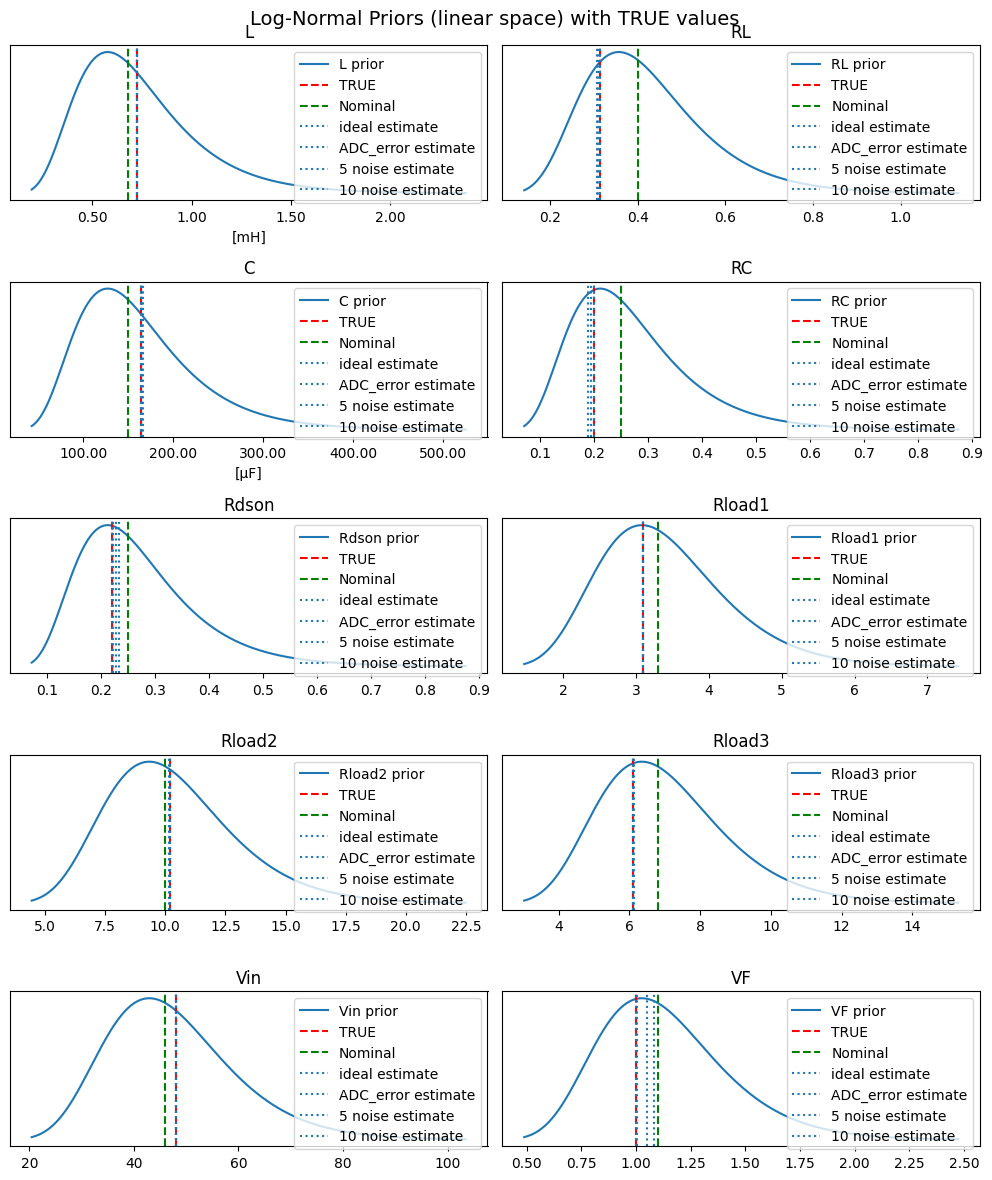

In [15]:
from typing import Dict
import matplotlib.pyplot as plt


# loop through all CSV files in the directory
csv_files = list(out_dir.glob("*.csv"))
runs = {}
for csv_file in csv_files:
    print(f"Processing {csv_file.name}")
    # noise_level = float(csv_file.stem.split("_")[-1])  # Extract noise level from filename
    # tr = TrainingRun.from_csv(csv_file)
    # runs[f"{noise_level}*LSB"] = tr.drop_columns(["learning_rate"])  # drop learning rate column

    label = csv_file.stem.removeprefix("noisy_run_")  # Extract label from filename
    tr = TrainingRun.from_csv(csv_file)
    runs[label] = tr.drop_columns(["learning_rate"])  # drop learning rate column

GROUP_NUMBER_DICT = {
    0: "ideal",
    1: "ADC_error",
    2: "Sync Error",
    3: "5 noise",
    4: "10 noise",
    5: "ADC-Sync-5noise",
    6: "ADC-Sync-10noise",
}
runs_ordered: Dict[str, TrainingRun] = {
    GROUP_NUMBER_DICT[ii]: runs[GROUP_NUMBER_DICT[ii]] for ii in (0, 1, 3, 4)
}

# Plotting
param_names = Parameters._fields
ncols = 2
nrows = int(np.ceil(len(param_names) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12))
axes = axes.flatten()


for i, name in enumerate(param_names):
    nominal = getattr(NOMINAL, name)
    rel_tol = getattr(REL_TOL, name)
    true_val = getattr(TRUE_PARAMS, name)
    estimations_for_different_runs: Dict[str, Parameters] = {
        label: getattr(run.best_parameters, name) for label, run in runs_ordered.items()
    }

    # log-normal parameters
    sigma = np.log(1 + rel_tol)
    mu = np.log(nominal)

    dist = lognorm(s=sigma, scale=np.exp(mu))

    x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 500)
    pdf = dist.pdf(x)

    ax = axes[i]
    ax.plot(x, pdf, label=f"{name} prior")
    ax.axvline(true_val, color="red", linestyle="--", label="TRUE")

    # plot the nominal value
    ax.axvline(nominal, color="green", linestyle="--", label="Nominal")

    for label, est in estimations_for_different_runs.items():
        ax.axvline(est, linestyle=":", label=f"{label} estimate")
    ax.set_title(name)
    ax.set_yticks([])
    ax.legend()

    if name == "L":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
        ax.set_xlabel("[mH]")
    if name == "C":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
        ax.set_xlabel("[μF]")

fig.suptitle("Log-Normal Priors (linear space) with TRUE values", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

## Laplace Approximation

The **Laplace approximation** is a method for approximating a complex posterior distribution with a Gaussian centered at the maximum a posteriori (MAP) estimate. It assumes that the log-posterior is approximately quadratic near its peak, allowing the posterior to be approximated as:

$$
p(\theta \mid \mathcal{D}) \approx \mathcal{N}(\theta_{\text{MAP}}, \Sigma), \quad \Sigma^{-1} = \nabla^2_{\theta} [-\log p(\theta \mid \mathcal{D})] \big|_{\theta = \theta_{\text{MAP}}}
$$

This approximation provides an estimate of uncertainty around the MAP point by evaluating the curvature (i.e., the Hessian) of the negative log-posterior. 

We use the Laplace approximation to fit a Gaussian (and optionally a log-normal) distribution to the posterior over the model parameters, enabling uncertainty quantification around the point estimate obtained by optimization.

In [16]:
from torch.autograd.functional import hessian
from torch.func import functional_call
from scipy.stats import norm, lognorm


@dataclass
class LaplacePosterior:
    theta_log: torch.Tensor
    Sigma_log: torch.Tensor
    theta_phys: torch.Tensor
    Sigma_phys: torch.Tensor


def get_map_logparams(model: torch.nn.Module) -> torch.Tensor:
    """Get flattened MAP estimate in log-space from a trained model."""
    return torch.cat([p.view(1) for p in model.logparams]).detach().clone().requires_grad_()


def posterior_loss_fn(model, X, y, NOMINAL, REL_TOL, noise_power) -> Callable:
    y_prev = X[:, :2].detach().to(X.device)
    y = y.detach().to(X.device)

    def loss_on_params(theta_vec: torch.Tensor) -> torch.Tensor:
        param_keys = [f"log_{n}" for n in Parameters._fields]
        split_vals = [v.view_as(getattr(model, k)) for k, v in zip(param_keys, theta_vec)]

        new_params = {k: v for k, v in zip(param_keys, split_vals)}
        logparams = Parameters(*split_vals)

        preds = functional_call(model, new_params, (X, y))

        sigma_x = _parse_data_noise_to_sigma(noise_power)
        ll_loss = likelihood_loss(preds, y_prev, y, sigma_x)
        prior = log_normal_prior(
            logparams, NOMINAL, rel_tolerance_to_sigma(REL_TOL)
        )

        return ll_loss + prior 

    return loss_on_params

# add the noise power to the posterior loss function


def laplace_fit(model, X, y, NOMINAL, REL_TOL, noise_power, damping=1e-6) -> LaplacePosterior:
    """Returns mean (log-space), covariance (log-space), and physical-space versions."""
    theta_map = get_map_logparams(model)
    loss_fn = posterior_loss_fn(model, X, y, NOMINAL, REL_TOL, noise_power=noise_power)

    loss = loss_fn(theta_map)
    loss.backward()

    H = hessian(loss_fn, theta_map)
    
    # Force symmetry and positive definiteness
    H = (H + H.T) / 2
    
    # Invert the Hessian matrix with damping for numerical stability
    Sigma_log = torch.linalg.inv(H + damping * torch.eye(H.shape[0], device=H.device))

    # Convert to physical space
    theta_map_phys = torch.tensor(
        [getattr(model.get_estimates(), name) for name in Parameters._fields],
        device=Sigma_log.device,
    )
    param_transformation_jacobian = torch.diag(theta_map_phys)
    Sigma_phys = param_transformation_jacobian @ Sigma_log @ param_transformation_jacobian.T

    return LaplacePosterior(
        theta_log=theta_map.detach().clone(),
        Sigma_log=Sigma_log,
        theta_phys=theta_map_phys,
        Sigma_phys=Sigma_phys,
    )


def build_gaussian_approx(mean: np.ndarray, cov: np.ndarray):
    """Return scipy.stats.norm for each parameter."""
    std = np.sqrt(np.diag(cov))
    return [norm(loc=m, scale=s) for m, s in zip(mean, std)]


def build_lognormal_approx(mu_log: np.ndarray, sigma_log: np.ndarray):
    """Return scipy.stats.lognorm for each parameter."""
    return [lognorm(s=s, scale=np.exp(m)) for m, s in zip(mu_log, sigma_log)]


def print_parameter_uncertainty(theta_phys, Sigma_phys):
    std_phys = torch.sqrt(torch.diag(Sigma_phys))
    for i, name in enumerate(Parameters._fields):
        mean = theta_phys[i].item()
        std = std_phys[i].item()
        if np.isnan(std):
            std = 0.0
        print(f"{name:8s}: {mean:.3e} ± {std:.1e}  ({100*std/mean:.2f} %)")

In [17]:
label_noise_dict = {
    "ideal": 1e-6,
    "ADC_error": Sigma_tot_ADC,
    "5 noise": Sigma_tot_5,
    "10 noise": Sigma_tot_10
}

X

lfits = {}
io = LoaderH5(db_dir, h5filename)

for label, model in trained_models.items():
    
    noise_power = label_noise_dict[label]
    io.load(label)
    X, y = io.M.data
    
    X = torch.tensor(X, device=device)
    y = torch.tensor(y, device=device)
    
    lfit = laplace_fit(model, X, y, NOMINAL, REL_TOL, noise_power=noise_power, damping=1e-6)
    gaussians = build_gaussian_approx(lfit.theta_phys.cpu().numpy(), lfit.Sigma_phys.cpu().numpy())
    lognormals = build_lognormal_approx(
        lfit.theta_log.cpu().numpy(), np.sqrt(torch.diag(lfit.Sigma_log).cpu().numpy())
    )
    print(f"\nParameter estimates for {label}:")
    print_parameter_uncertainty(lfit.theta_phys, lfit.Sigma_phys)
    lfits[label] = lfit



Parameter estimates for ideal:
L       : 7.250e-04 ± 5.6e-07  (0.08 %)
RL      : 3.140e-01 ± 5.8e-04  (0.19 %)
C       : 1.645e-04 ± 7.7e-08  (0.05 %)
RC      : 2.009e-01 ± 3.6e-05  (0.02 %)
Rdson   : 2.210e-01 ± 6.9e-04  (0.31 %)
Rload1  : 3.100e+00 ± 1.3e-04  (0.00 %)
Rload2  : 1.020e+01 ± 1.4e-03  (0.01 %)
Rload3  : 6.100e+00 ± 4.9e-04  (0.01 %)
Vin     : 4.800e+01 ± 1.9e-02  (0.04 %)
VF      : 1.000e+00 ± 1.9e-02  (1.93 %)

Parameter estimates for ADC_error:
L       : 7.252e-04 ± 1.9e-06  (0.26 %)
RL      : 3.136e-01 ± 2.0e-03  (0.64 %)
C       : 1.645e-04 ± 7.7e-07  (0.47 %)
RC      : 2.008e-01 ± 3.5e-04  (0.18 %)
Rdson   : 2.219e-01 ± 2.4e-03  (1.07 %)
Rload1  : 3.100e+00 ± 1.3e-03  (0.04 %)
Rload2  : 1.020e+01 ± 1.3e-02  (0.13 %)
Rload3  : 6.099e+00 ± 4.9e-03  (0.08 %)
Vin     : 4.801e+01 ± 6.3e-02  (0.13 %)
VF      : 1.003e+00 ± 6.5e-02  (6.48 %)

Parameter estimates for 5 noise:
L       : 7.250e-04 ± 6.1e-06  (0.84 %)
RL      : 3.107e-01 ± 9.7e-03  (3.13 %)
C       : 1.655e-0

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm
import numpy as np


def plot_laplace_posteriors(
    lfit: LaplacePosterior,
    NOMINAL: Parameters,
    REL_TOL: Parameters,
    TRUE_PARAMS: Parameters,
    _SCALE: dict,
    runs_ordered: dict,
):
    """
    Plot Laplace approximations (Gaussian + log-normal) against log-normal prior for each parameter.
    """
    param_names = Parameters._fields
    ncols = 2
    nrows = int(np.ceil(len(param_names) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 14))
    axes = axes.flatten()

    # Convert tensors to numpy
    theta_map_np = lfit.theta_phys.cpu().numpy()
    std_map_np = np.sqrt(torch.diag(lfit.Sigma_phys).cpu().numpy())
    mu_log_np = lfit.theta_log.cpu().detach().numpy()
    sigma_log_np = np.sqrt(torch.diag(lfit.Sigma_log).cpu().numpy())

    for i, name in enumerate(param_names):
        nominal = getattr(NOMINAL, name)
        rel_tol = getattr(REL_TOL, name)
        true_val = getattr(TRUE_PARAMS, name)
        mu_post = theta_map_np[i]
        std_post = std_map_np[i]

        # Prior distribution
        sigma_prior = np.log(1 + rel_tol)
        mu_prior = np.log(nominal)
        prior_dist = lognorm(s=sigma_prior, scale=np.exp(mu_prior))
        x_prior = np.linspace(prior_dist.ppf(0.001), prior_dist.ppf(0.999), 500)
        y_prior = prior_dist.pdf(x_prior)

        # Posterior (Gaussian)
        x_post_gauss = np.linspace(mu_post - 4 * std_post, mu_post + 4 * std_post, 500)
        y_post_gauss = norm(loc=mu_post, scale=std_post).pdf(x_post_gauss)

        # Posterior (log-normal, Laplace)
        mu_log = mu_log_np[i] - np.log(_SCALE[name])  # adjust for scale
        sigma_log = sigma_log_np[i]
        post_dist = lognorm(s=sigma_log, scale=np.exp(mu_log))
        x_post = np.linspace(post_dist.ppf(0.001), post_dist.ppf(0.999), 500)
        y_post = post_dist.pdf(x_post)

        ax = axes[i]
        ax.plot(x_prior, y_prior, label="Prior (log-normal)", color="blue", linewidth=1)
        ax.plot(
            x_post_gauss,
            y_post_gauss,
            label="Laplace Posterior (Gaussian)",
            color="orange",
            linewidth=1,
        )
        ax.plot(x_post, y_post, label="Laplace Posterior (log-normal)", color="black", linewidth=2)

        # markers
        ax.axvline(true_val, color="red", linestyle="--", label="TRUE")
        ax.axvline(nominal, color="green", linestyle="--", label="Nominal")
        ax.axvline(mu_post, color="purple", linestyle="-.", label="MAP Estimate")
        
        # point estimates from other runs
        # for label, run in runs_ordered.items():
        #     est = getattr(run.best_parameters, name)
        #     ax.axvline(est, linestyle=":", label=f"{label} estimate")

        ax.set_title(name)
        ax.set_yticks([])

        # Format axis labels
        if name == "L":
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
            ax.set_xlabel("[mH]")
        elif name == "C":
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
            ax.set_xlabel("[μF]")

        ax.legend(fontsize="x-small", loc="upper right")

    fig.suptitle("Prior (log-normal) and Laplace Posterior for Each Parameter", fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

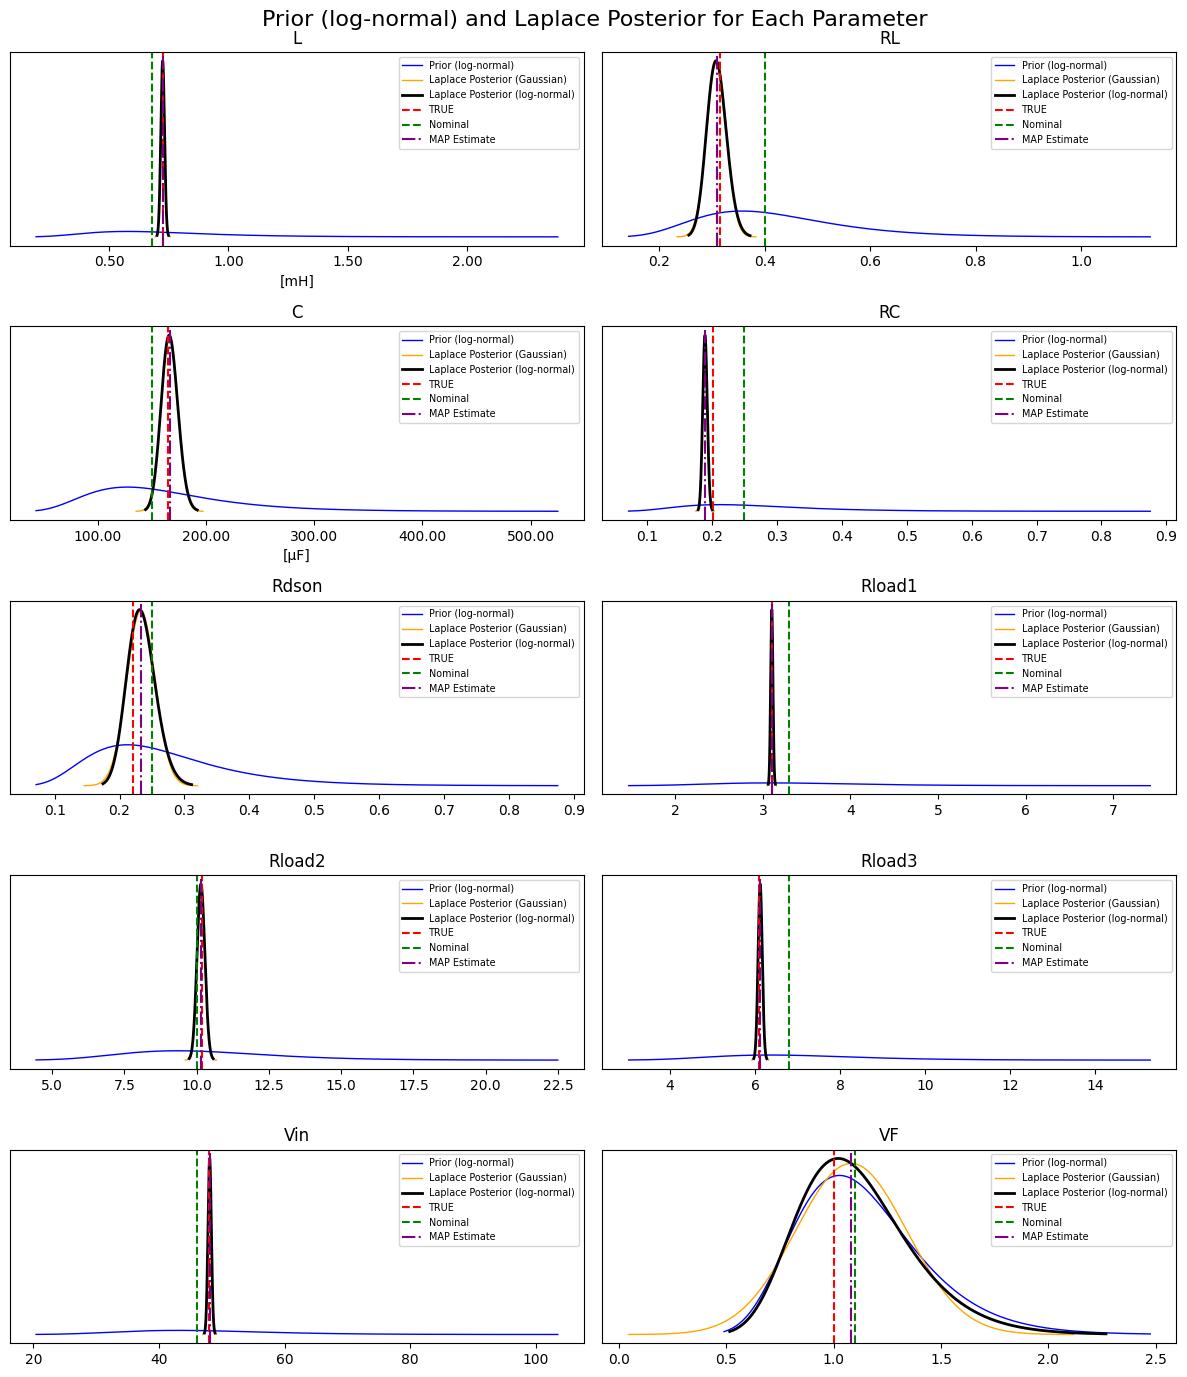

In [19]:
label = "10 noise"  # change this to "ideal", "5 noise", or "10 noise" as needed

lfit = lfits[label]
plot_laplace_posteriors(
    lfit = lfit,
    NOMINAL=NOMINAL,
    REL_TOL=REL_TOL,
    TRUE_PARAMS=TRUE_PARAMS,
    _SCALE=_SCALE,
    runs_ordered=runs_ordered,
)

In [20]:
def plot_single_laplace_posterior(
    param_name: str,
    lfit: LaplacePosterior,
    _SCALE: dict,
    ax: plt.Axes,
    label: str,
    style: str = "log-normal",  # or "gaussian"
    color: str = None,
    plot_prior: bool = False,
    NOMINAL: Parameters = None,
    REL_TOL: Parameters = None,
    TRUE_PARAMS: Parameters = None,
    show_map_marker: bool = True,
    marker_kwargs: dict = None,
):
    """
    Plot a single Laplace posterior distribution and optionally the prior,
    with a square marker at the MAP estimate placed on the PDF curve.

    Args:
        param_name: name of the parameter
        theta_phys: MAP in physical units
        Sigma_phys: covariance in physical units
        theta_log: MAP in log space
        Sigma_log: covariance in log space
        _SCALE: scaling dictionary
        ax: matplotlib axis to draw on
        label: label for the posterior
        style: 'log-normal' or 'gaussian'
        color: curve and marker color
        plot_prior: show log-normal prior
        NOMINAL, REL_TOL: required if plot_prior is True
        show_map_marker: draw square on posterior at MAP
        marker_kwargs: customization for square marker
    """
    param_names = Parameters._fields
    idx = param_names.index(param_name)

    mu_post = lfit.theta_phys[idx].item()
    std_post = float(torch.sqrt(lfit.Sigma_phys[idx, idx]))

    if plot_prior:
        if NOMINAL is None or REL_TOL is None:
            raise ValueError("NOMINAL and REL_TOL must be provided to plot the prior.")
        nominal = getattr(NOMINAL, param_name)
        rel_tol = getattr(REL_TOL, param_name)
        sigma_prior = np.log(1 + rel_tol)
        mu_prior = np.log(nominal)
        prior_dist = lognorm(s=sigma_prior, scale=np.exp(mu_prior))
        x_prior = np.linspace(prior_dist.ppf(0.001), prior_dist.ppf(0.999), 500)
        y_prior = prior_dist.pdf(x_prior)
        ax.plot(x_prior, y_prior, label="Prior (log-normal)", color="black", linewidth=2)
        if show_map_marker:
            y_nominal_prior = prior_dist.pdf(nominal)
            default_marker_kwargs = {"marker": "s", "color": "black", "s": 30, "zorder": 5}
            ax.scatter([nominal], [y_nominal_prior], **default_marker_kwargs)

    if style == "gaussian":
        x = np.linspace(mu_post - 4 * std_post, mu_post + 4 * std_post, 500)
        y = norm(loc=mu_post, scale=std_post).pdf(x)
        (line,) = ax.plot(x, y, label=label, color=color, linewidth=1)
        if show_map_marker:
            y_map = norm(loc=mu_post, scale=std_post).pdf(mu_post)
    elif style == "log-normal":
        mu_log = lfit.theta_log[idx].item() - np.log(_SCALE[param_name])
        sigma_log = float(torch.sqrt(lfit.Sigma_log[idx, idx]))
        dist = lognorm(s=sigma_log, scale=np.exp(mu_log))
        x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 500)
        y = dist.pdf(x)
        (line,) = ax.plot(x, y, label=label, color=color, linewidth=1)
        if show_map_marker:
            y_map = dist.pdf(mu_post)
    else:
        raise ValueError(f"Unknown style '{style}'; use 'gaussian' or 'log-normal'.")

    line_color = line.get_color() if color is None else color

    # Add square marker on the curve at the MAP
    if show_map_marker:
        default_marker_kwargs = {"marker": "s", "color": line_color, "s": 30, "zorder": 5}
        if marker_kwargs:
            default_marker_kwargs.update(marker_kwargs)
        ax.scatter([mu_post], [y_map], **default_marker_kwargs)

    if TRUE_PARAMS is not None:
        true_val = getattr(TRUE_PARAMS, param_name)
        ax.axvline(true_val, color="red", linestyle="--", label="TRUE", linewidth=1)

    ax.set_title(param_name)
    ax.set_yticks([])

    if param_name == "L":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
        ax.set_xlabel("[mH]")
    elif param_name == "C":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
        ax.set_xlabel("[μF]")

def plot_all_laplace_posteriors_grid(
    lfits: dict[str, LaplacePosterior],
    NOMINAL: Parameters,
    REL_TOL: Parameters,
    _SCALE: dict,
    TRUE_PARAMS: Parameters = None,
    skip_labels: set = {"ideal"},
    style: str = "log-normal",
):
    """
    Plot posterior PDFs from Laplace approximation for all parameters in a grid.

    Args:
        trained_models: dict[label] -> trained model
        X, y: input data tensors
        NOMINAL, REL_TOL: prior hyperparams
        _SCALE: scaling dict
        label_noise_dict: dict[label] -> data_noise_power
        TRUE_PARAMS: optional, used to show true value marker
        skip_labels: set of labels to skip (e.g. 'ideal')
        style: 'log-normal' or 'gaussian'
    """
    param_names = Parameters._fields
    ncols = 2
    nrows = int(np.ceil(len(param_names) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 14))
    axes = axes.flatten()

    for i, param_name in enumerate(param_names):
        ax = axes[i]
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)

        # Only show prior and true param once
        show_prior = True
        true_params = TRUE_PARAMS

        for label, fit in lfits.items():
            if label in skip_labels:
                continue
            plot_single_laplace_posterior(
                param_name=param_name,
                lfit=fit,
                _SCALE=_SCALE,
                ax=ax,
                label=label,
                style=style,
                plot_prior=show_prior,
                NOMINAL=NOMINAL,
                REL_TOL=REL_TOL,
                show_map_marker=True,
                marker_kwargs={"label": None},  # avoid duplicate legend entry
                TRUE_PARAMS=true_params,
            )
            if show_prior:
                show_prior = False  # only plot once
            true_params = None

        # Add true value line (if provided)
        if TRUE_PARAMS:
            true_val = getattr(TRUE_PARAMS, param_name)
            ax.axvline(true_val, color="red", linestyle="--", label="TRUE")

        ax.set_title(param_name)
        ax.legend(fontsize="x-small", loc="upper right")

    fig.suptitle("Laplace Posteriors with Varying Data Noise", fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

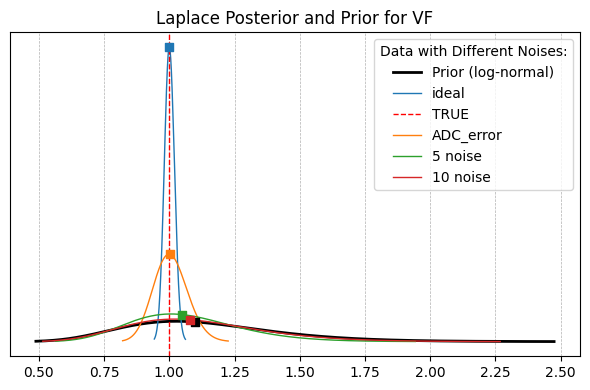

In [21]:
parameter_name = "VF"


fig, ax = plt.subplots(figsize=(6, 4))
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plot_prior = True
true_params = TRUE_PARAMS
for label, lfit in lfits.items():

    plot_single_laplace_posterior(
        param_name=parameter_name,
        lfit = lfit,
        _SCALE=_SCALE,
        ax=ax,
        label=label,
        style="log-normal",
        plot_prior=plot_prior,
        NOMINAL=NOMINAL,
        REL_TOL=REL_TOL,
        TRUE_PARAMS=true_params,
    )

    ax.legend(title="Data with Different Noises:")
    ax.set_title("Laplace Posterior and Prior for " + parameter_name)
    plt.tight_layout()
    plot_prior = False  # only plot prior once
    true_params = None  # don't plot TRUE_PARAMS again

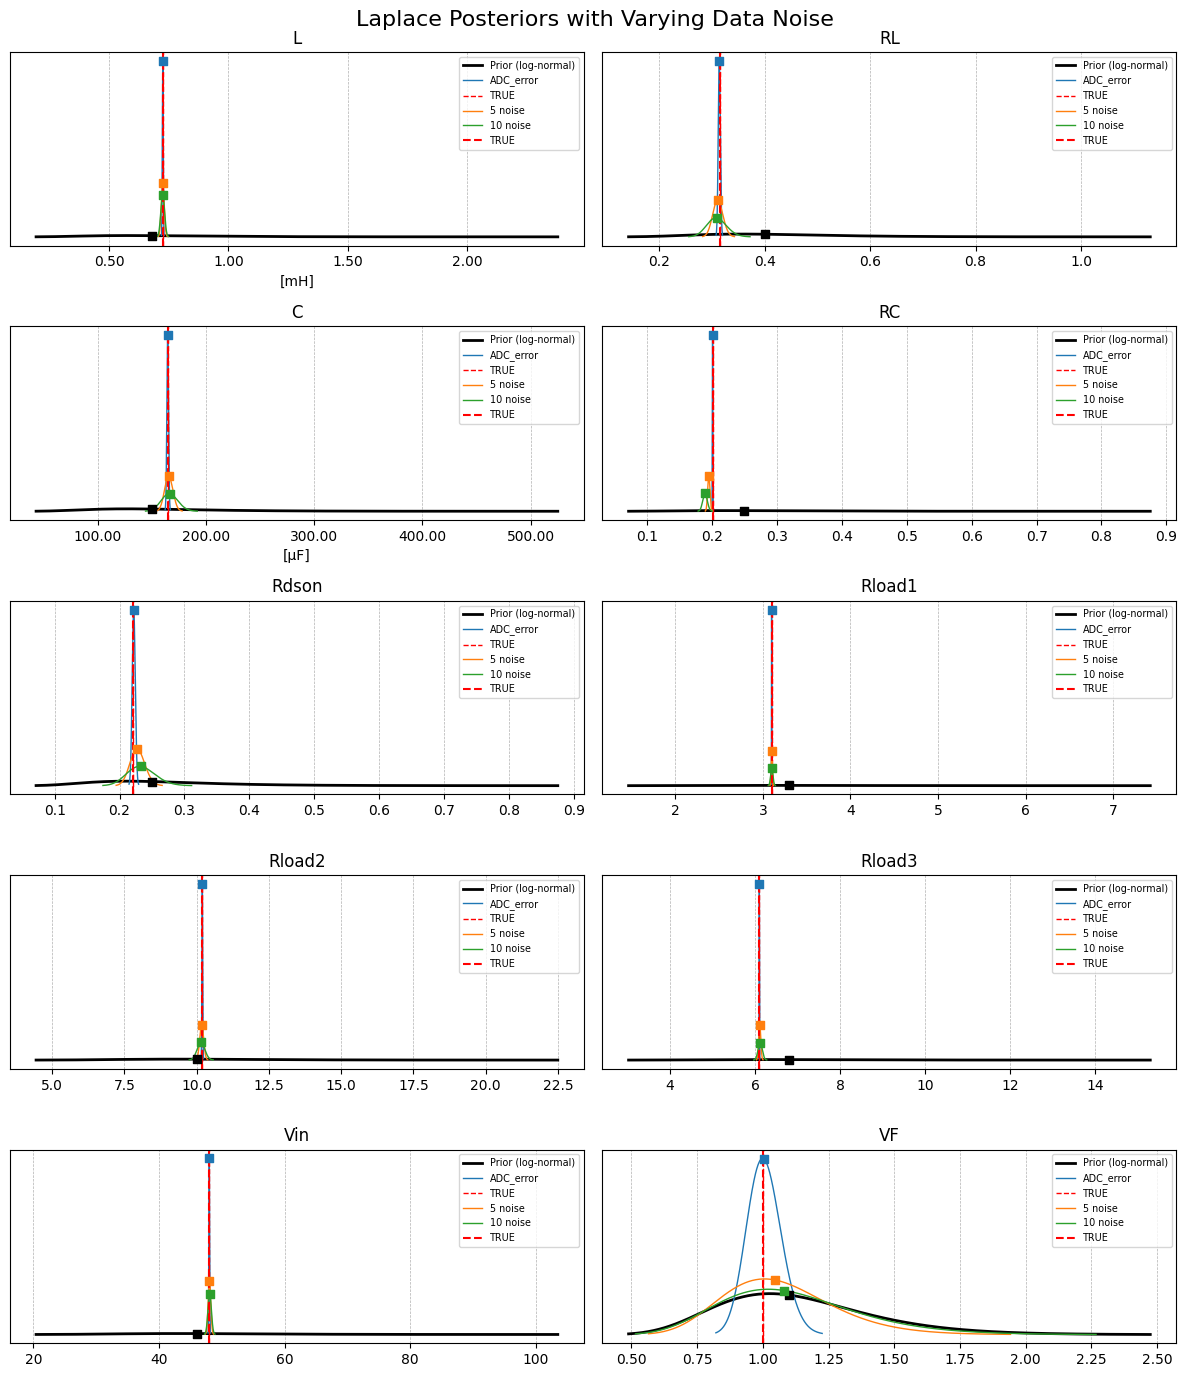

In [22]:
plot_all_laplace_posteriors_grid(
    lfits=lfits,
    NOMINAL=NOMINAL,
    REL_TOL=REL_TOL,
    _SCALE=_SCALE,
    TRUE_PARAMS=TRUE_PARAMS,
)

Great! We have obtained posterior distributions on the estimations, which depend on the nose of the input data. 


## Limitations

#### 0. Choice of Priors 
The choice of priors is done by inspection

## Remedies and Next Steps

For points 1 and 3 we can think of different approaches to solve this problem. 

1. Rather than simply considering $x_{\text{obs}}$, estimate the true x considering this as a latent variable

2. Model the noise scale explicitly, learning $\sigma^2$ as a latent variable.

2. Use full Bayesian inference, these return better estimations of the posterior p(z | y, x): 
    + VI approach: should still be possible to use automatic-diff + Adam. 
    + HMC / NUTS: Since we only have 10 dimensions, there is no curse of dimensionality. Should be possible to draw **exact values from the posterior** without relying on surrogate models.  

---

Also, the prior effect is quite strong when the data is noisy. This may be correct and could be resolved with the previous points, but we can see what happens if we use uniform priors or **empirical Bayes**, which are chosen in a data-driven manner (maybe we can keep the nominal and only estimate $\sigma$ in this way). 